In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from visualization import Scatter, NullPlot, TimeBar
from visualization import Hourly_plot, Daymean_plot, Monthly_plot

# Load data

In [3]:
Jd_df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Jd_df.csv')
print(Jd_df.shape)
Jd_df.head()

(58118, 13)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,12.8,0.9,200.0,83.0,1019.1,NaN,NaN,NaN,22,2014-05-09,전남 진도군,0.0,5
1,12.2,0.9,230.0,87.0,1019.0,NaN,NaN,NaN,23,2014-05-09,전남 진도군,0.0,5
2,11.4,0.2,0.0,82.0,1019.6,NaN,NaN,NaN,0,2014-05-10,전남 진도군,0.0,5
3,10.9,0.1,0.0,83.0,1019.4,NaN,NaN,NaN,1,2014-05-10,전남 진도군,0.0,5
4,15.6,2.6,110.0,77.0,1019.2,NaN,NaN,NaN,2,2014-05-10,전남 진도군,0.0,5


In [4]:
Jd_df['Date'].str[:4].unique()

array(['2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

In [5]:
Mp_df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Mp_df.csv')
print(Mp_df.shape)
Mp_df.head()

(78887, 13)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,-2.0,4.1,160.0,93.0,1021.4,NaN,3.0,2000.0,0,2013-01-01,전남 목포시,0.0,1
1,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,1,2013-01-01,전남 목포시,0.0,1
2,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,2,2013-01-01,전남 목포시,0.0,1
3,-2.7,3.6,160.0,95.0,1020.8,NaN,7.0,1800.0,3,2013-01-01,전남 목포시,0.0,1
4,-2.9,4.0,160.0,94.0,1020.0,NaN,7.0,1800.0,4,2013-01-01,전남 목포시,0.0,1


In [6]:
Mp_df['Date'].str[:4].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

# Mokpo Area

## Delete Nighttime & Missing values

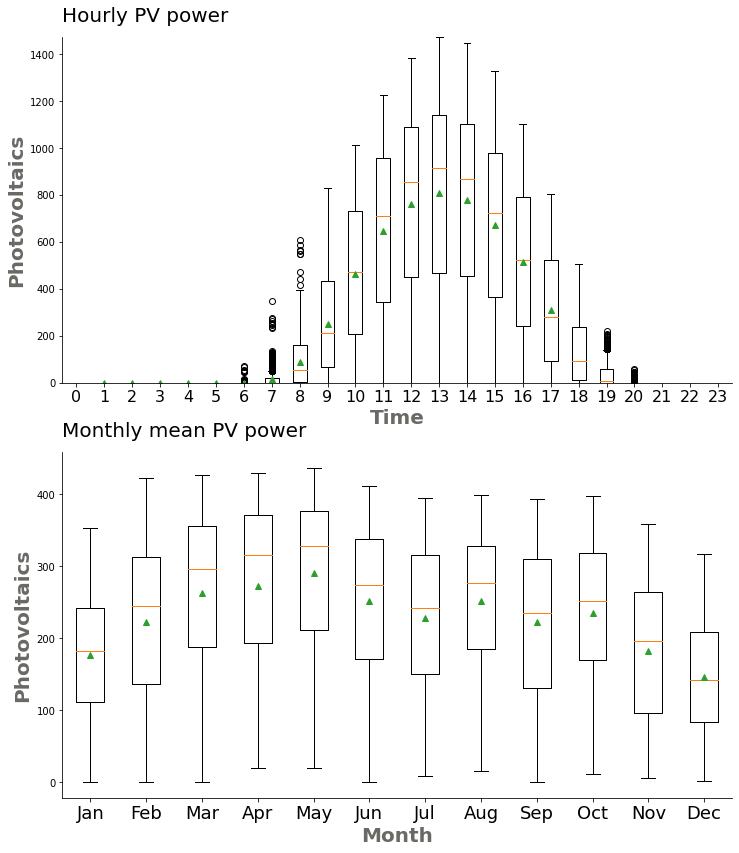

In [7]:
fig, [ax1, ax2] = plt.subplots(figsize=(12, 14), nrows=2, ncols=1)
Hourly_plot(Mp_df, 'Photovoltaics', ax1)
Daymean_plot(Mp_df, 'Photovoltaics', ax2)

In [8]:
def Drop_idx(df, drop_times):
  data = df.copy()
  drop_idx = []
  night_idx = data[data['Time'].isin(drop_times)].index # 밤 시간대 제거
  zero_idx = data[data['Photovoltaics'] == 0].index # 그 외에도 발전량이 0인 행 제거
  drop_idx.extend([i for i in night_idx])
  drop_idx.extend([i for i in zero_idx])
  data.drop(drop_idx, inplace=True)
  data.dropna(subset=['Photovoltaics'], inplace=True)
  data.reset_index(inplace=True, drop=True)
  return data

In [9]:
drop_times = [0, 1, 2, 3, 4, 5, 21, 22, 23]
daytime_Mp = Drop_idx(Mp_df, drop_times)
print(f'Time : ', np.sort(daytime_Mp['Time'].unique()))
daytime_Mp

Time :  [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,2.6,6.0,290.0,91.0,1019.6,0.0,10.0,1300.0,9,2013-01-01,전남 목포시,20.16,1
1,4.2,5.8,250.0,82.0,1019.9,0.7,7.0,1300.0,10,2013-01-01,전남 목포시,106.80,1
2,3.8,7.1,320.0,80.0,1020.5,0.7,9.0,1300.0,11,2013-01-01,전남 목포시,469.56,1
3,4.9,2.8,290.0,73.0,1020.1,0.7,7.0,1300.0,12,2013-01-01,전남 목포시,504.24,1
4,5.2,6.7,320.0,66.0,1019.7,0.8,6.0,1100.0,13,2013-01-01,전남 목포시,745.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40105,-0.2,5.9,360.0,79.0,1031.4,0.2,9.0,1206.0,14,2021-12-31,전남 목포시,312.00,12
40106,-0.7,5.0,360.0,83.0,1031.4,0.0,10.0,1040.0,15,2021-12-31,전남 목포시,163.80,12
40107,-0.6,5.1,360.0,83.0,1031.5,0.0,10.0,1057.0,16,2021-12-31,전남 목포시,103.44,12
40108,0.6,6.9,360.0,69.0,1031.1,0.0,9.0,2000.0,17,2021-12-31,전남 목포시,45.36,12


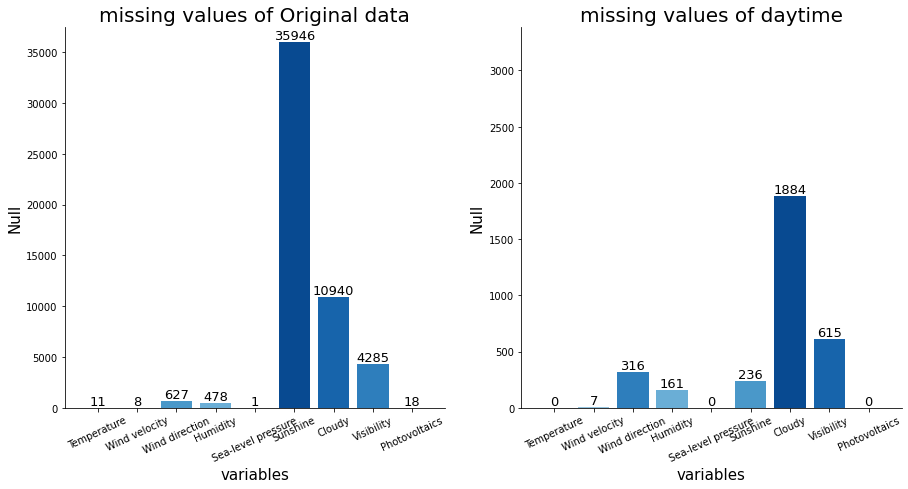

In [10]:
fig, [ax1, ax2] = plt.subplots(figsize=(15, 7), nrows=1, ncols=2)
NullPlot(Mp_df, 'missing values of Original data', ax1)
NullPlot(daytime_Mp, 'missing values of daytime', ax2)

In [11]:
missing_Mp = daytime_Mp.dropna(how='any') 
missing_Mp.reset_index(inplace=True, drop=True)
missing_Mp.shape 

(37728, 13)

## Delete outlier

In [12]:
missing_Mp['Date'].str[:4].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

In [13]:
Mp_cols = [i for i in missing_Mp.columns if i not in ['Date', 'Area', 'Time', 'Month']]
Mp_cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Cloudy',
 'Visibility',
 'Photovoltaics']

In [14]:
def outlier_plot(df, stand_df, cols):
  plt.figure(figsize=(20, 15))
  for idx, col in enumerate(cols):
    #이상치 기준
    q1 = stand_df[col].quantile(0.25)
    q3 = stand_df[col].quantile(0.75)
    iqr = q3 - q1
    iqr_weight =  iqr*1.5
    # 분포 그리기
    ax = plt.subplot(3, 3, 1+idx)
    sns.histplot(df[col], kde=False, ax=ax)
    ax.set_title(f'{col}', fontsize=12)
    # 이상치 영역 박스 그리기
    plt.axvspan(xmin=q1-iqr_weight, xmax=stand_df[col].min(), alpha=0.2, color='red')
    plt.axvspan(xmin=q3+iqr_weight, xmax=stand_df[col].max(), alpha=0.2, color='red')
  plt.show()

In [15]:
def Outlier_data(area_df, cols):
  df = area_df.copy()
  for col in cols:
    q1 = area_df[col].quantile(0.25)
    q3 = area_df[col].quantile(0.75)
    iqr = q3 - q1
    iqr_weight = iqr*1.5

    max_out = df[df[col] > q3 + iqr_weight].index
    min_out = df[df[col] < q1 - iqr_weight].index
    df = df.drop(max_out)
    df = df.drop(min_out)
    num = len(max_out)+len(min_out)
    print(f'{col} outlier data : {num}')
  df.reset_index(inplace=True, drop=True)
  return df

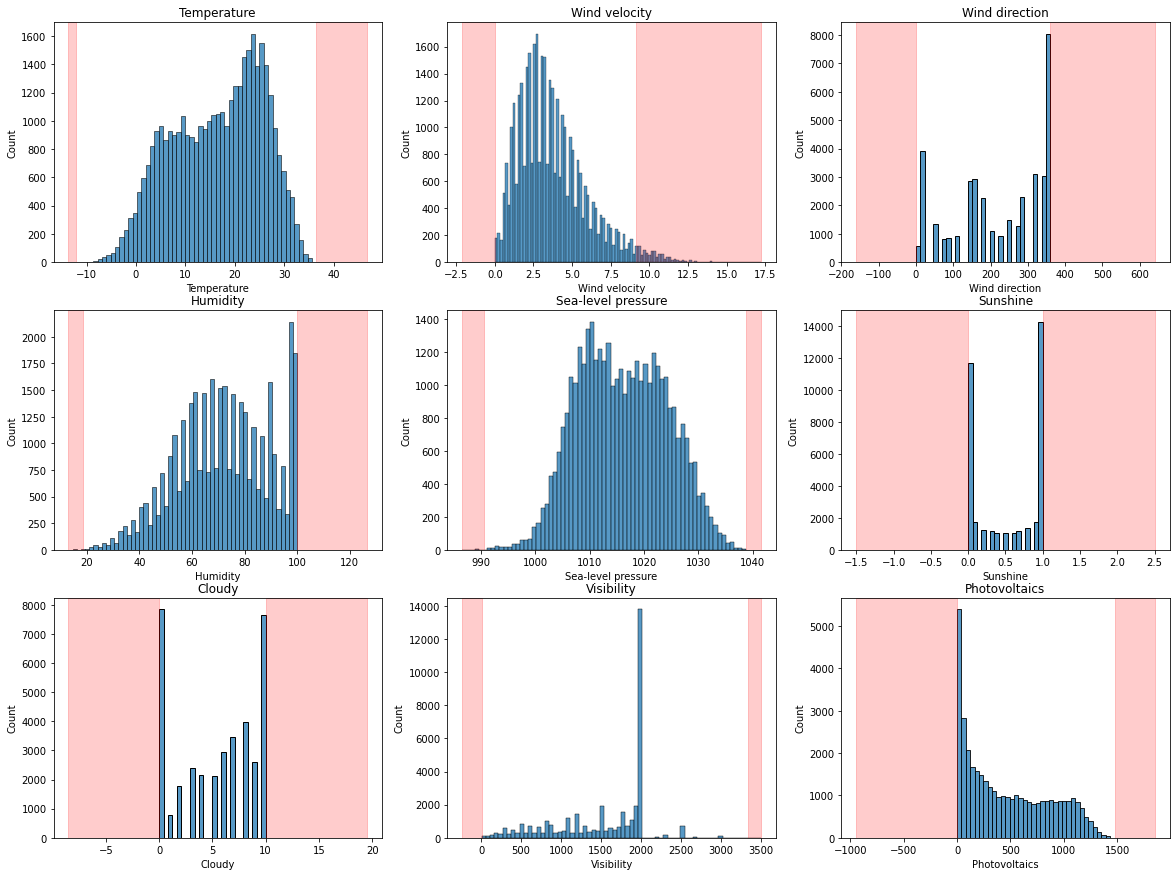

In [16]:
outlier_plot(missing_Mp, missing_Mp, Mp_cols)

In [17]:
result_Mp = missing_Mp.copy()
result_Mp.shape

(37728, 13)

In [18]:
result_Mp = Outlier_data(result_Mp, Mp_cols)
result_Mp.shape 

Temperature outlier data : 0
Wind velocity outlier data : 1034
Wind direction outlier data : 0
Humidity outlier data : 17
Sea-level pressure outlier data : 7
Sunshine outlier data : 0
Cloudy outlier data : 0
Visibility outlier data : 7
Photovoltaics outlier data : 0


(36663, 13)

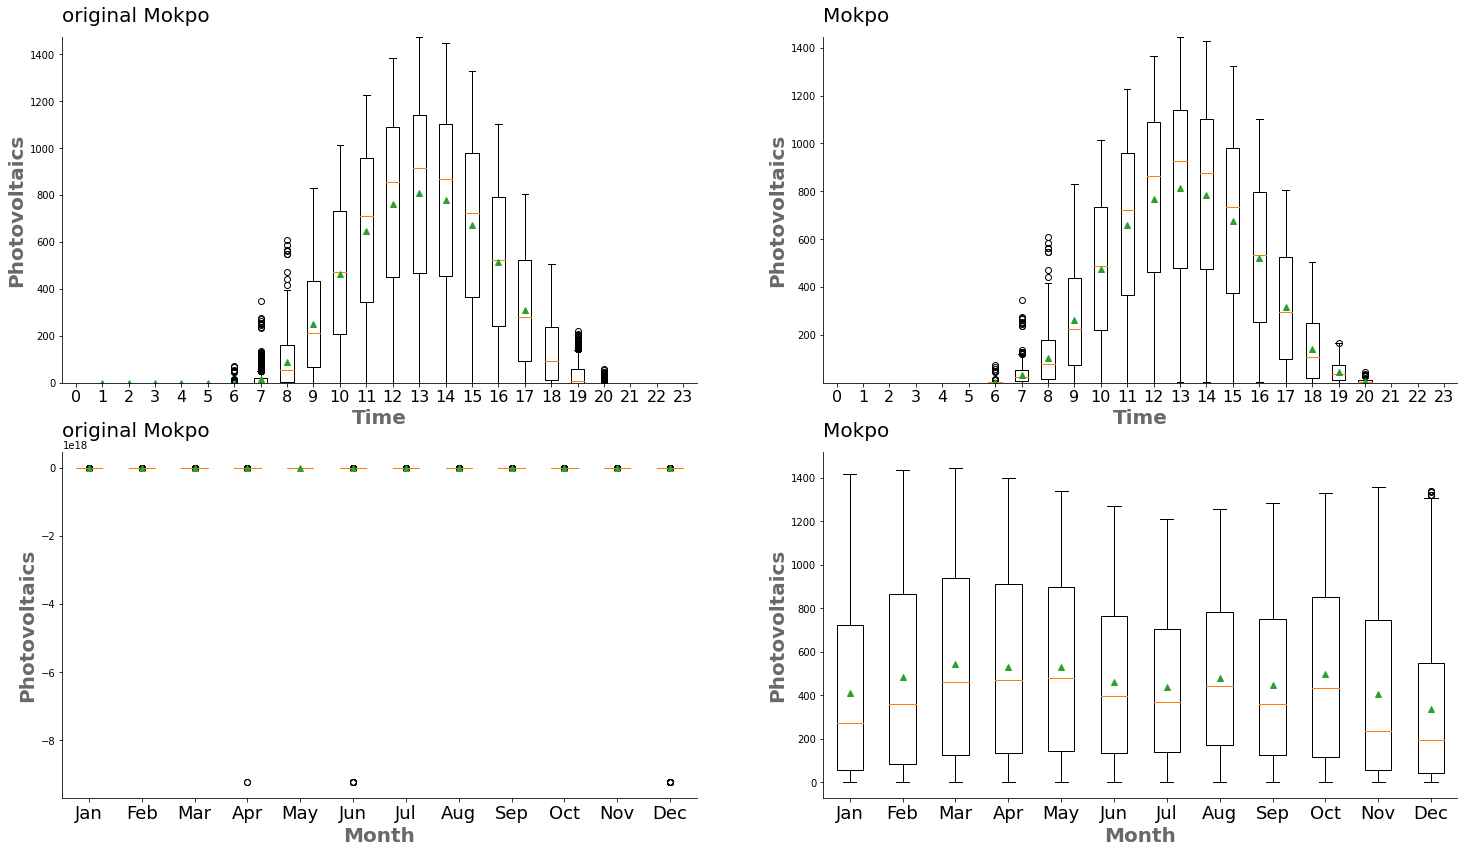

In [19]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(25, 14), nrows=2, ncols=2)
Hourly_plot(Mp_df, 'Photovoltaics', ax1, 'original Mokpo')
Monthly_plot(Mp_df, 'Photovoltaics', ax3, 'original Mokpo')
Hourly_plot(result_Mp, 'Photovoltaics', ax2, 'Mokpo')
Monthly_plot(result_Mp, 'Photovoltaics', ax4, 'Mokpo')

# Jindo Area

## Delete Nighttime & Missing values

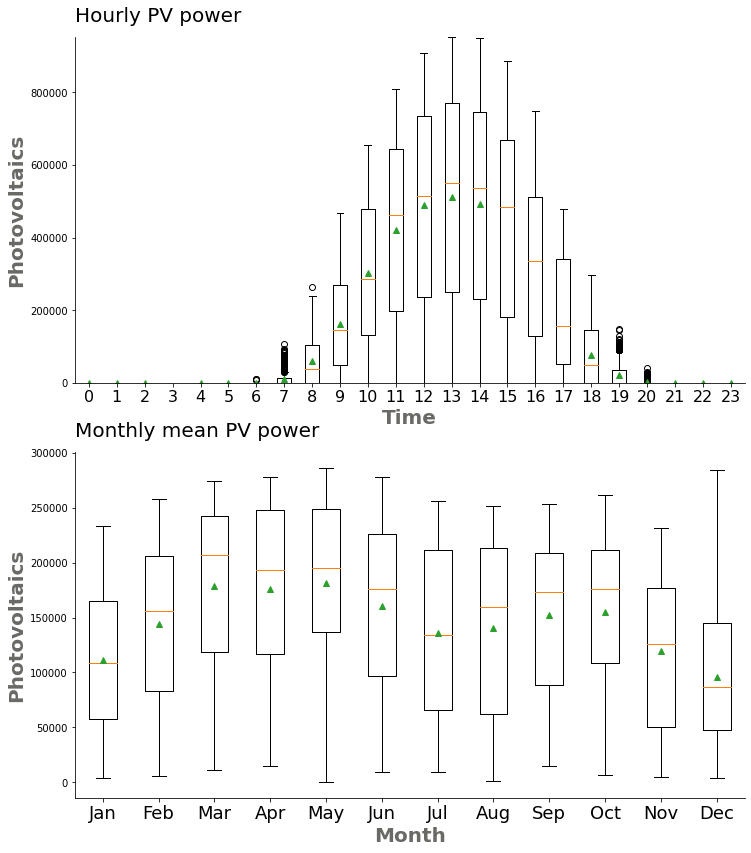

In [20]:
fig, [ax1, ax2] = plt.subplots(figsize=(12, 14), nrows=2, ncols=1)
Hourly_plot(Jd_df, 'Photovoltaics', ax1)
Daymean_plot(Jd_df, 'Photovoltaics', ax2)

In [21]:
drop_times = [0, 1, 2, 3, 4, 5, 21, 22, 23]
daytime_Jd = Drop_idx(Jd_df, drop_times)
print(f'Time : ', np.sort(daytime_Jd['Time'].unique()))
daytime_Jd

Time :  [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,16.4,3.1,90.0,52.0,1019.5,NaN,NaN,NaN,7,2014-05-10,전남 진도군,60120.0,5
1,17.7,2.2,90.0,49.0,1019.6,NaN,NaN,NaN,8,2014-05-10,전남 진도군,202032.0,5
2,19.1,3.5,90.0,34.0,1019.8,NaN,NaN,NaN,9,2014-05-10,전남 진도군,317016.0,5
3,20.1,4.4,110.0,33.0,1020.0,NaN,NaN,NaN,10,2014-05-10,전남 진도군,529632.0,5
4,20.5,4.1,110.0,36.0,1019.6,NaN,NaN,NaN,11,2014-05-10,전남 진도군,623448.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26660,0.4,1.6,50.0,80.0,1026.0,0.4,9.0,1991.0,13,2020-12-31,전남 진도군,210168.0,12
26661,1.6,4.0,320.0,78.0,1025.2,0.1,9.0,2000.0,14,2020-12-31,전남 진도군,84528.0,12
26662,2.0,4.4,270.0,67.0,1024.9,0.4,7.0,2000.0,15,2020-12-31,전남 진도군,122400.0,12
26663,1.6,5.4,320.0,75.0,1025.1,0.3,10.0,1755.0,16,2020-12-31,전남 진도군,129816.0,12


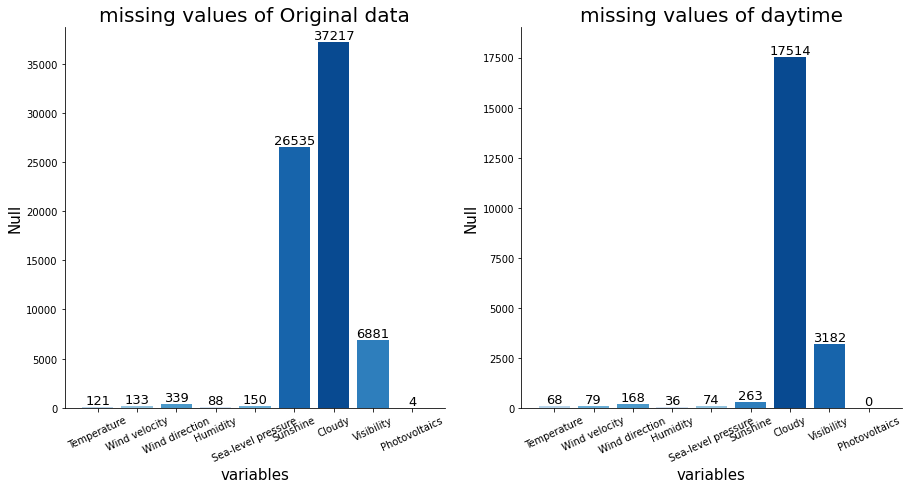

In [22]:
fig, [ax1, ax2] = plt.subplots(figsize=(15, 7), nrows=1, ncols=2)
NullPlot(Jd_df, 'missing values of Original data', ax1)
NullPlot(daytime_Jd, 'missing values of daytime', ax2)

In [23]:
daytime_Jd.drop(columns=['Cloudy'], inplace=True) 

In [24]:
missing_Jd = daytime_Jd.dropna(how='any') 
missing_Jd.reset_index(inplace=True, drop=True)
missing_Jd.shape 

(23320, 12)

## Delete outlier

In [25]:
Jd_cols = [i for i in missing_Jd.columns if i not in ['Date', 'Area', 'Time', 'Month']]
Jd_cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Visibility',
 'Photovoltaics']

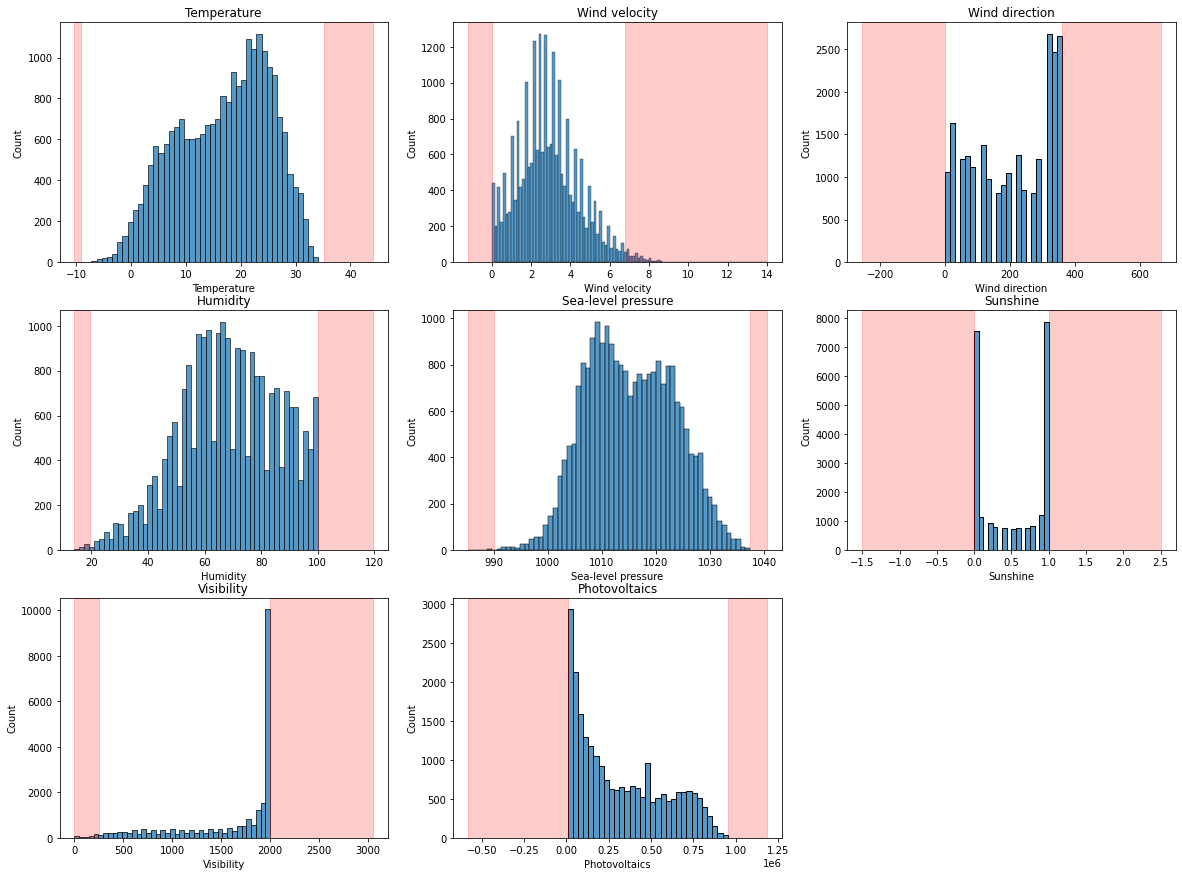

In [26]:
outlier_plot(missing_Jd, missing_Jd, Jd_cols)

In [27]:
result_Jd = missing_Jd.copy()
result_Jd.shape

(23320, 12)

In [28]:
result_Jd = Outlier_data(result_Jd, Jd_cols)
result_Jd.shape 

Temperature outlier data : 0
Wind velocity outlier data : 424
Wind direction outlier data : 0
Humidity outlier data : 44
Sea-level pressure outlier data : 4
Sunshine outlier data : 0
Visibility outlier data : 401
Photovoltaics outlier data : 0


(22447, 12)

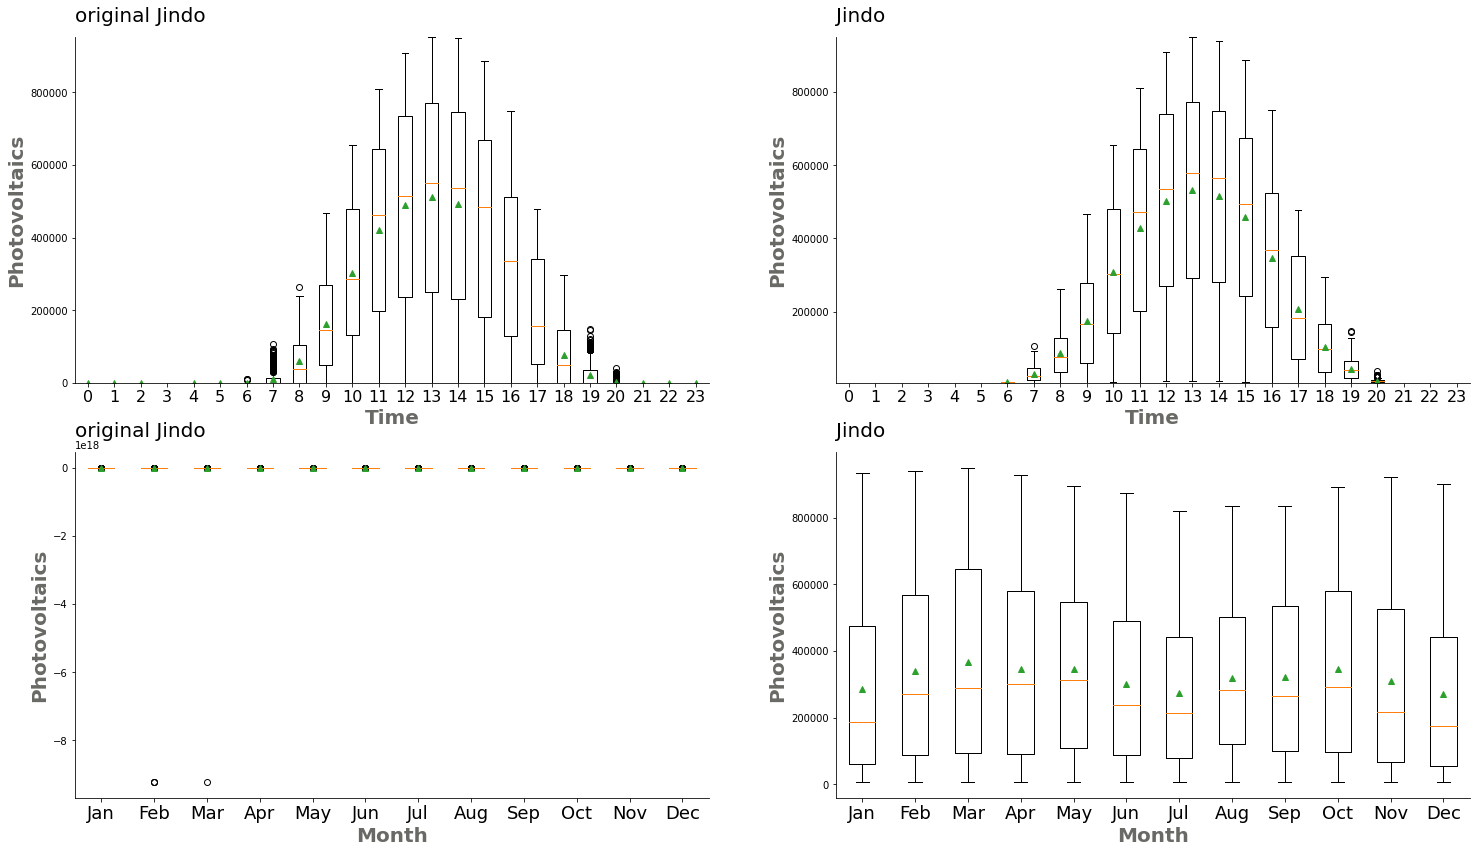

In [29]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(25, 14), nrows=2, ncols=2)
Hourly_plot(Jd_df, 'Photovoltaics', ax1, 'original Jindo')
Monthly_plot(Jd_df, 'Photovoltaics', ax3, 'original Jindo')
Hourly_plot(result_Jd, 'Photovoltaics', ax2, 'Jindo')
Monthly_plot(result_Jd, 'Photovoltaics', ax4, 'Jindo')

# Distribution of PV 

## Mokpo

In [30]:
def Month_set(data, names, Months):
  fig = plt.figure(figsize=(30, 12), dpi=100)
  plt.suptitle(names, y= 0.97, fontsize=20)
  for idx,i in enumerate(Months):
    axes = plt.subplot(2, 3, idx+1)
    ind = data[data['Month'] == i].index
    Hourly_plot(data.loc[ind], 'Photovoltaics', axes, f'{i} Month')

In [31]:
year_Mp = result_Mp['Date'].str[:4].unique()
for i in year_Mp:
  data = result_Mp[result_Mp['Date'].str[:4] == i]
  print(i,':', len(data))

2013 : 4004
2014 : 3874
2015 : 3706
2016 : 4062
2017 : 3973
2018 : 4127
2019 : 4340
2020 : 4254
2021 : 4323


In [32]:
test_data = result_Mp[result_Mp['Date'].str[:4] == year_Mp.max()]
train_data = result_Mp.loc[:test_data.index[0]-1]

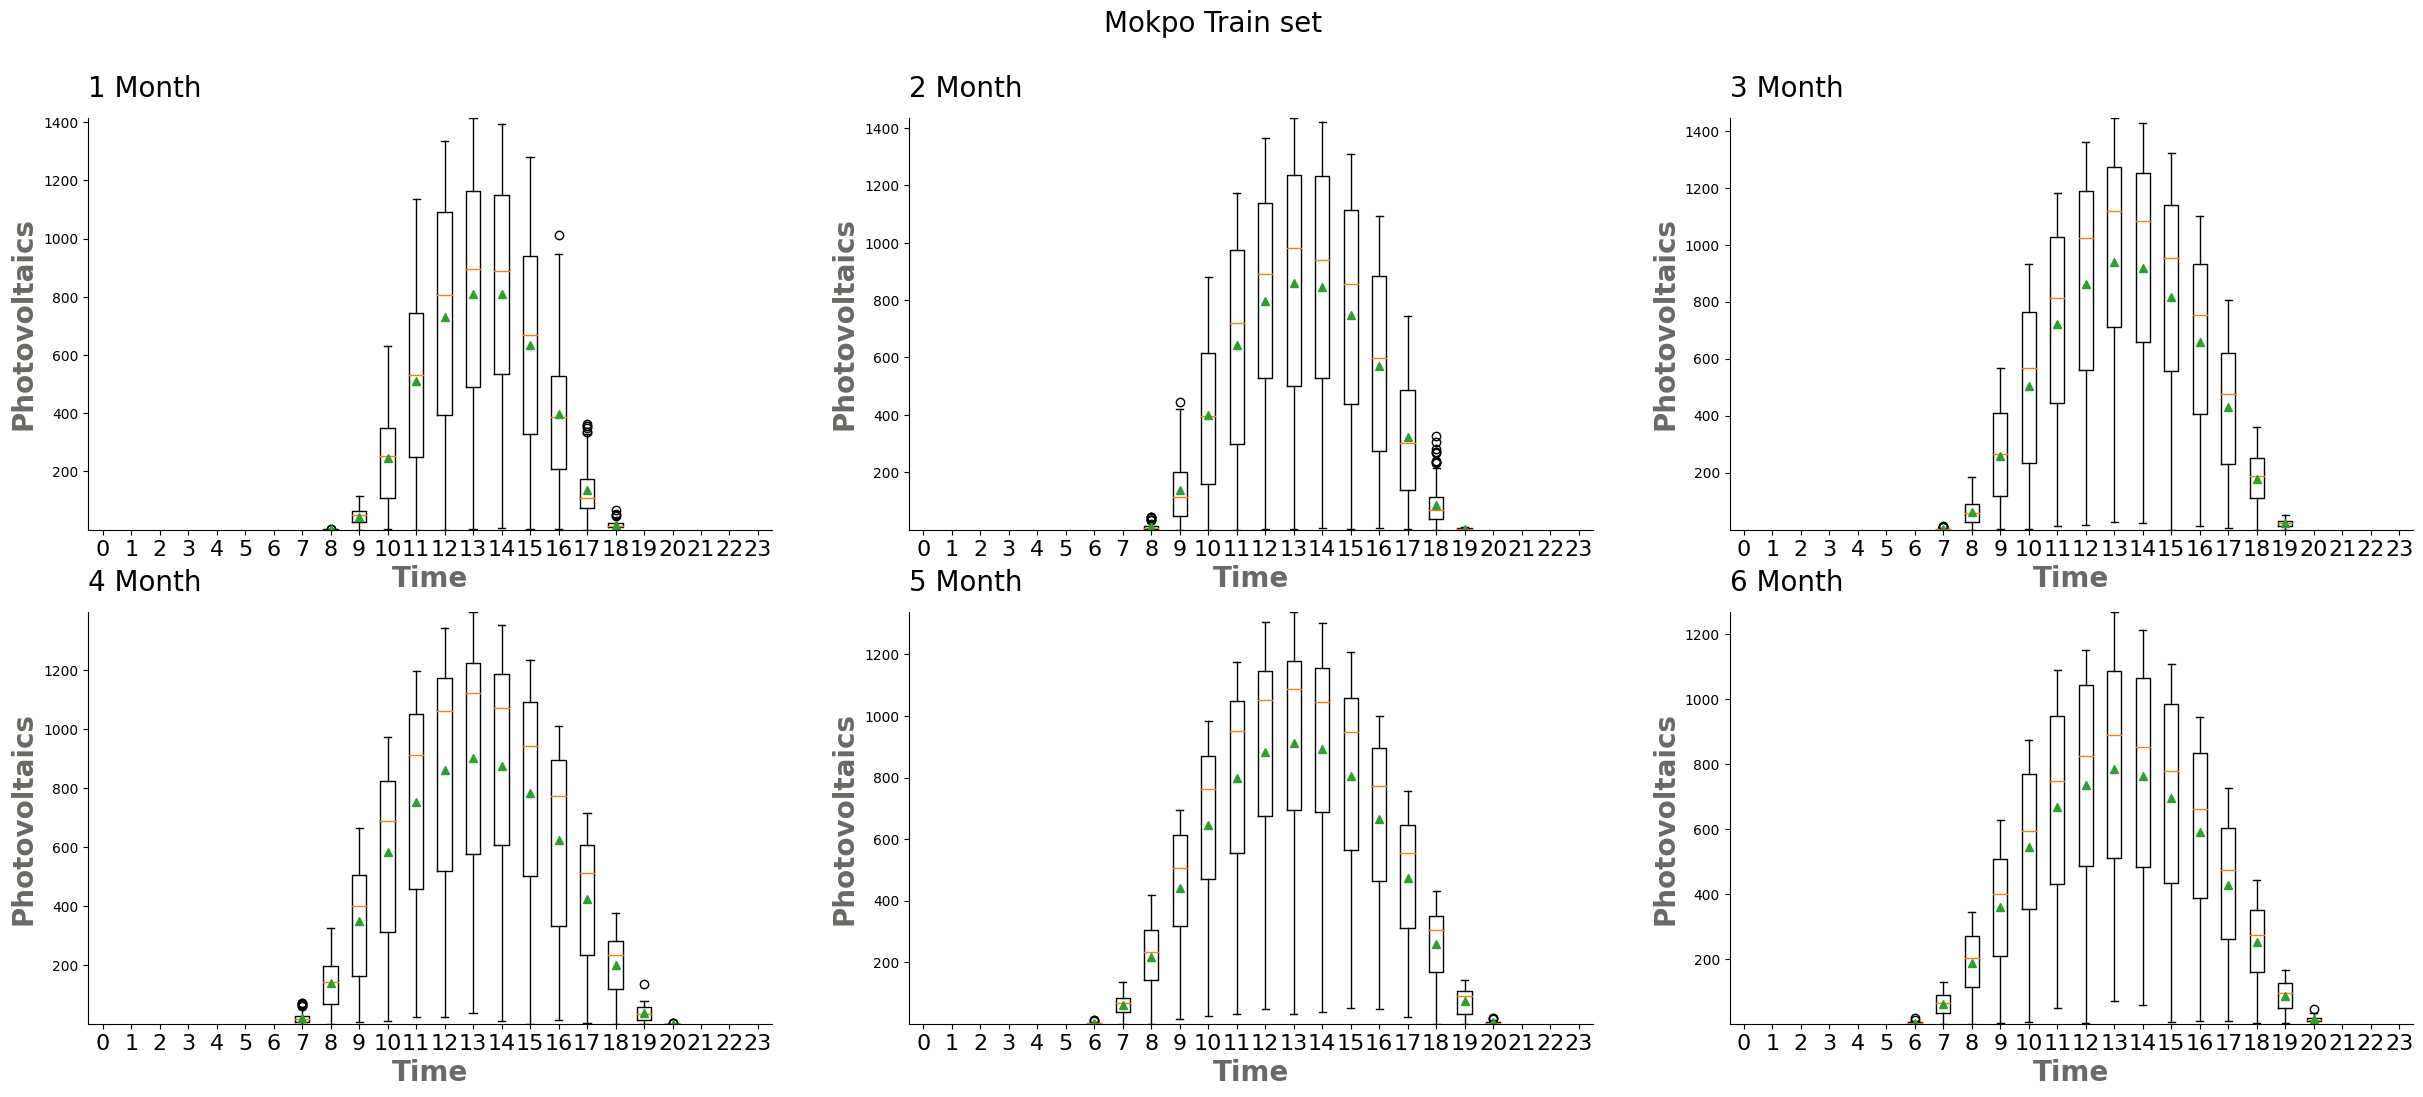

In [33]:
Months = range(1, 7)
Month_set(train_data, 'Mokpo Train set', Months)

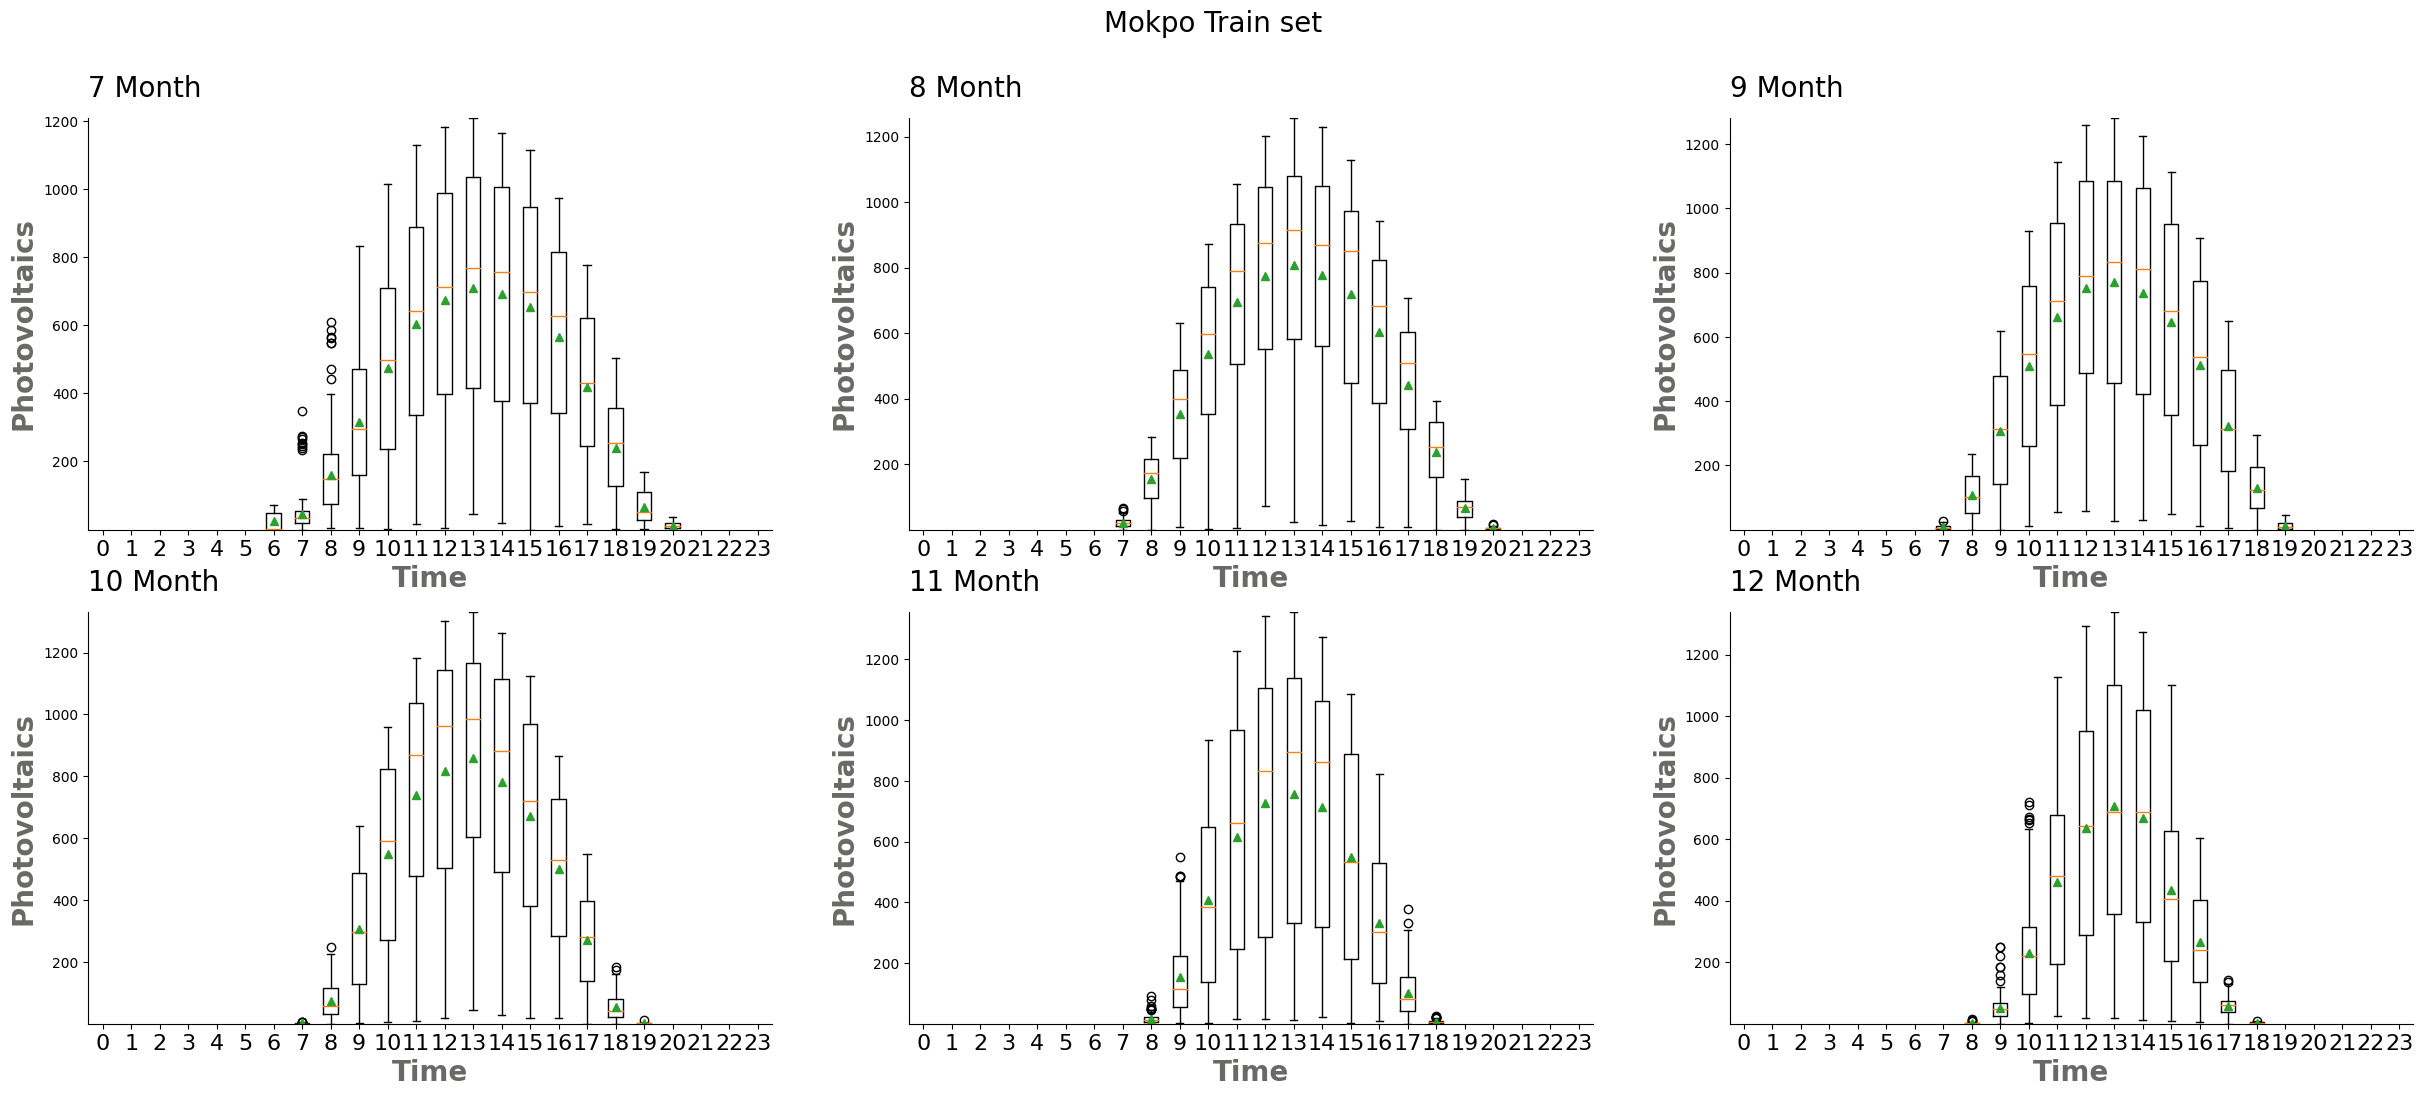

In [34]:
Months = range(7, 13)
Month_set(train_data, 'Mokpo Train set', Months)

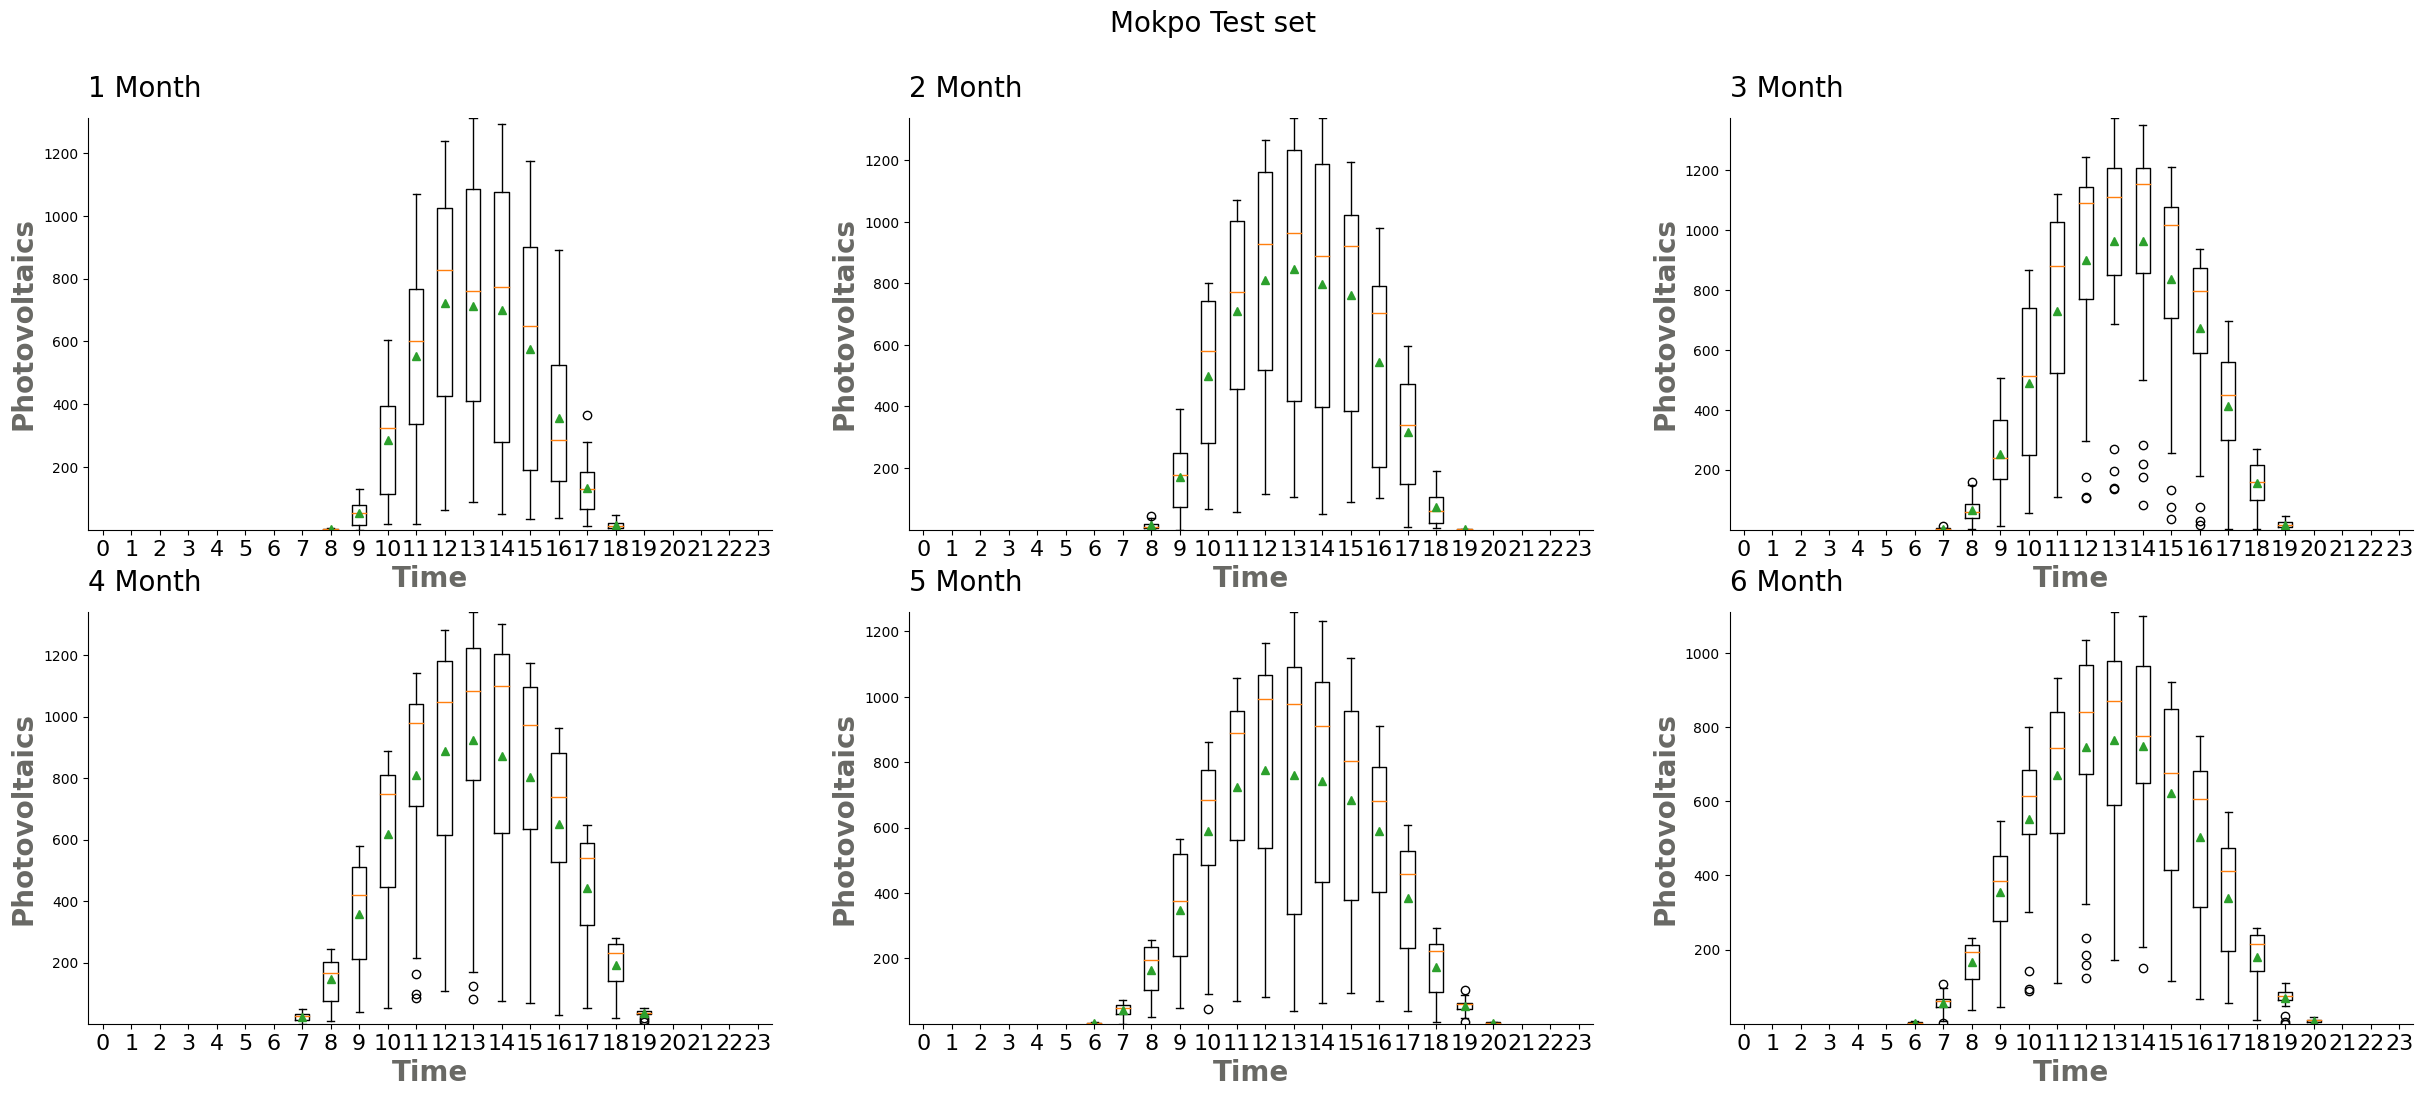

In [35]:
Months = range(1, 7)
Month_set(test_data, 'Mokpo Test set', Months)

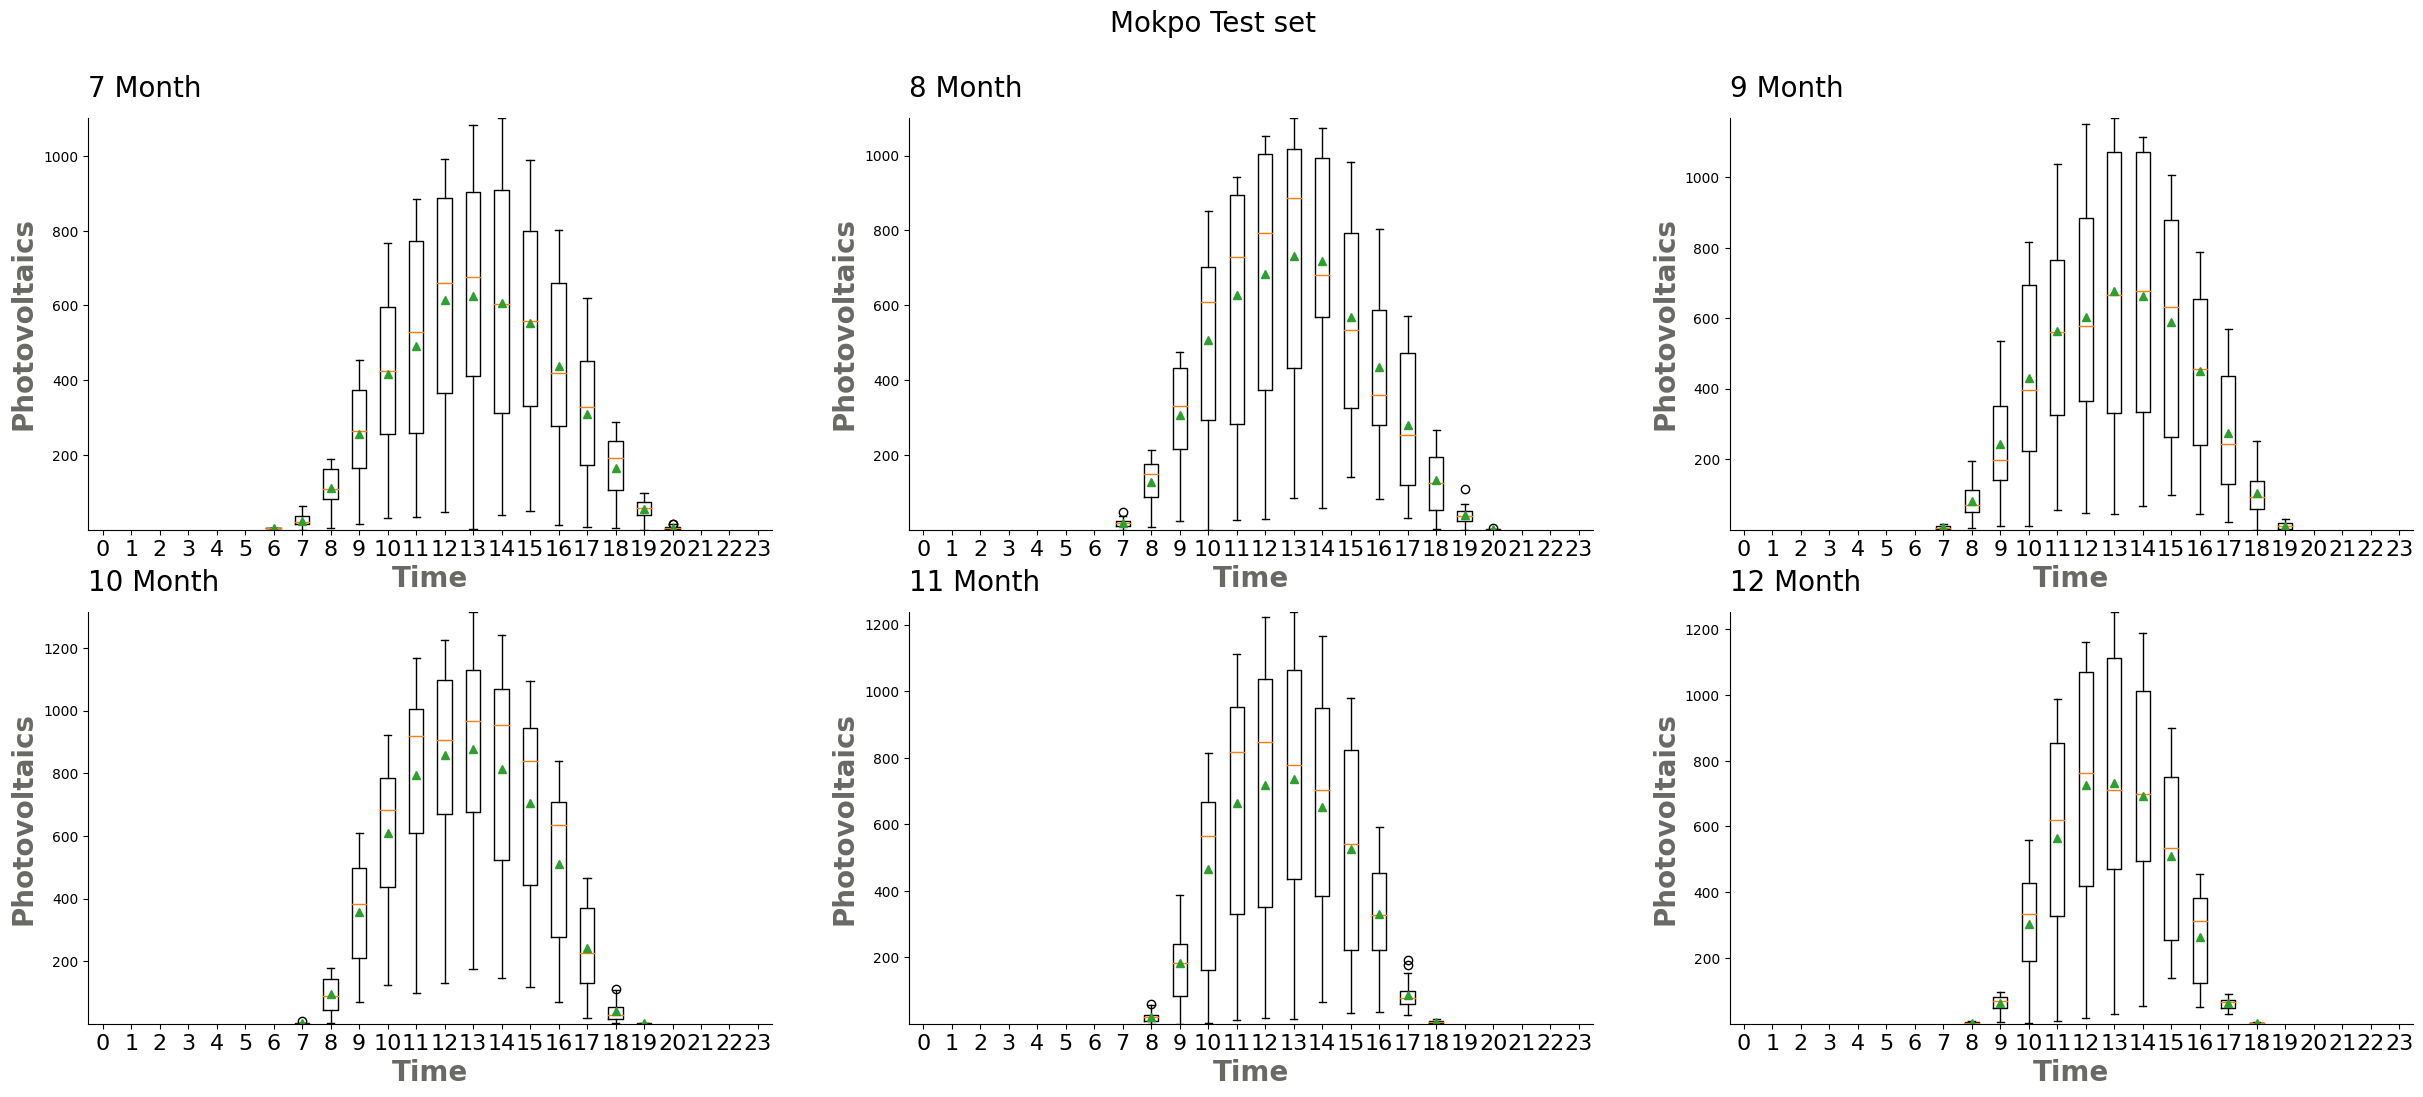

In [36]:
Months = range(7, 13)
Month_set(test_data, 'Mokpo Test set', Months)

## Jindo

In [37]:
year_Jd = result_Jd['Date'].str[:4].unique()
for i in year_Jd:
  data = result_Jd[result_Jd['Date'].str[:4] == i]
  print(i,':', len(data))

2015 : 3465
2016 : 3916
2017 : 3899
2018 : 3776
2019 : 3628
2020 : 3763


In [38]:
test_data = result_Jd[result_Jd['Date'].str[:4] == year_Jd.max()]
train_data = result_Jd.loc[:test_data.index[0]-1]
print(train_data.shape, test_data.shape)

(18684, 12) (3763, 12)


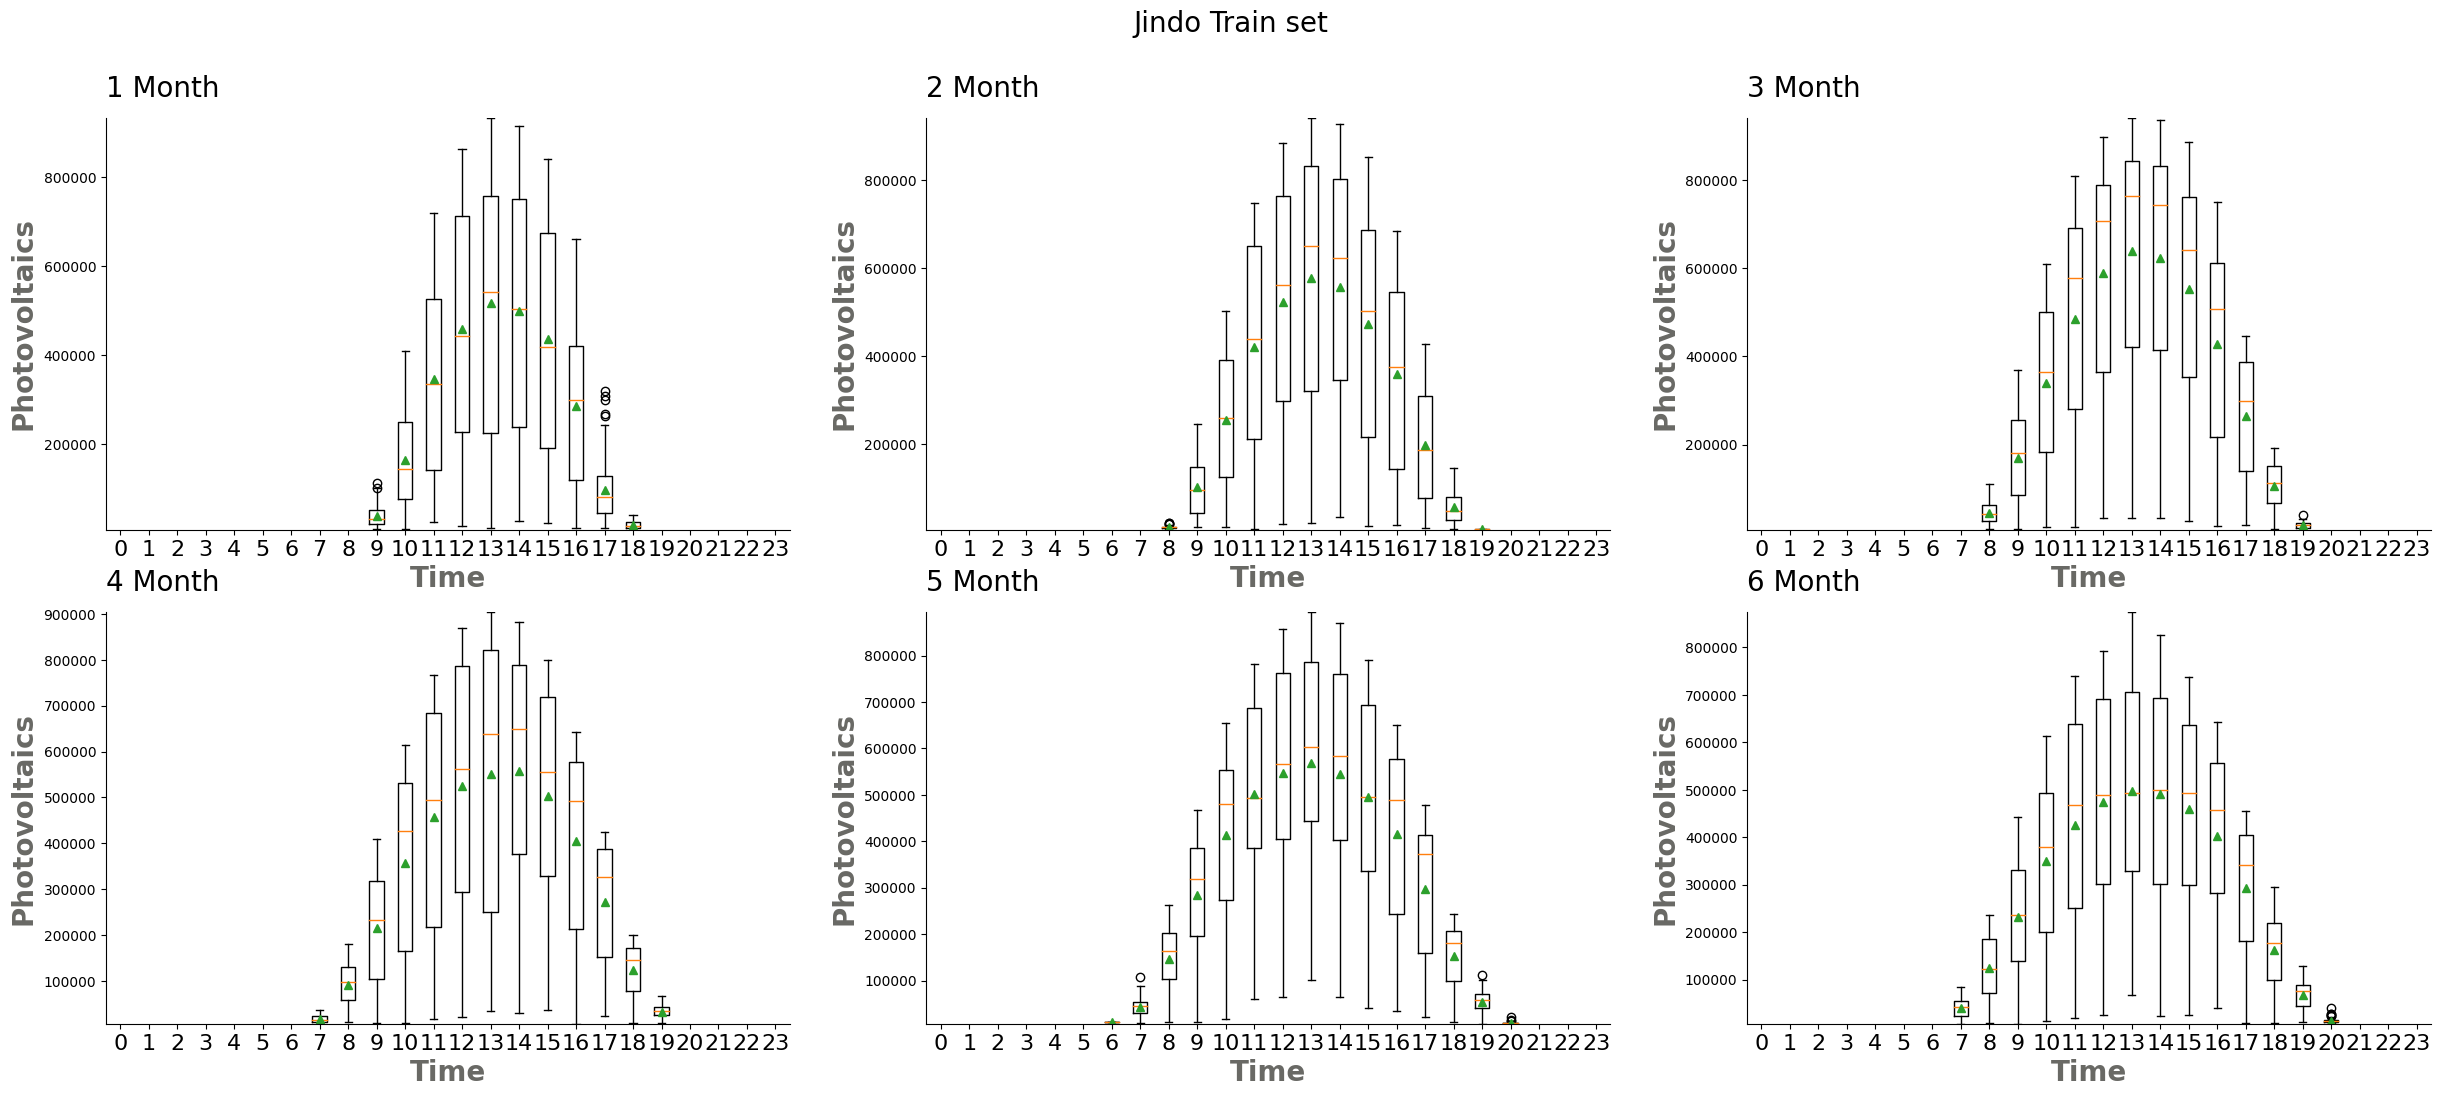

In [39]:
Months = range(1, 7)
Month_set(train_data, 'Jindo Train set', Months)

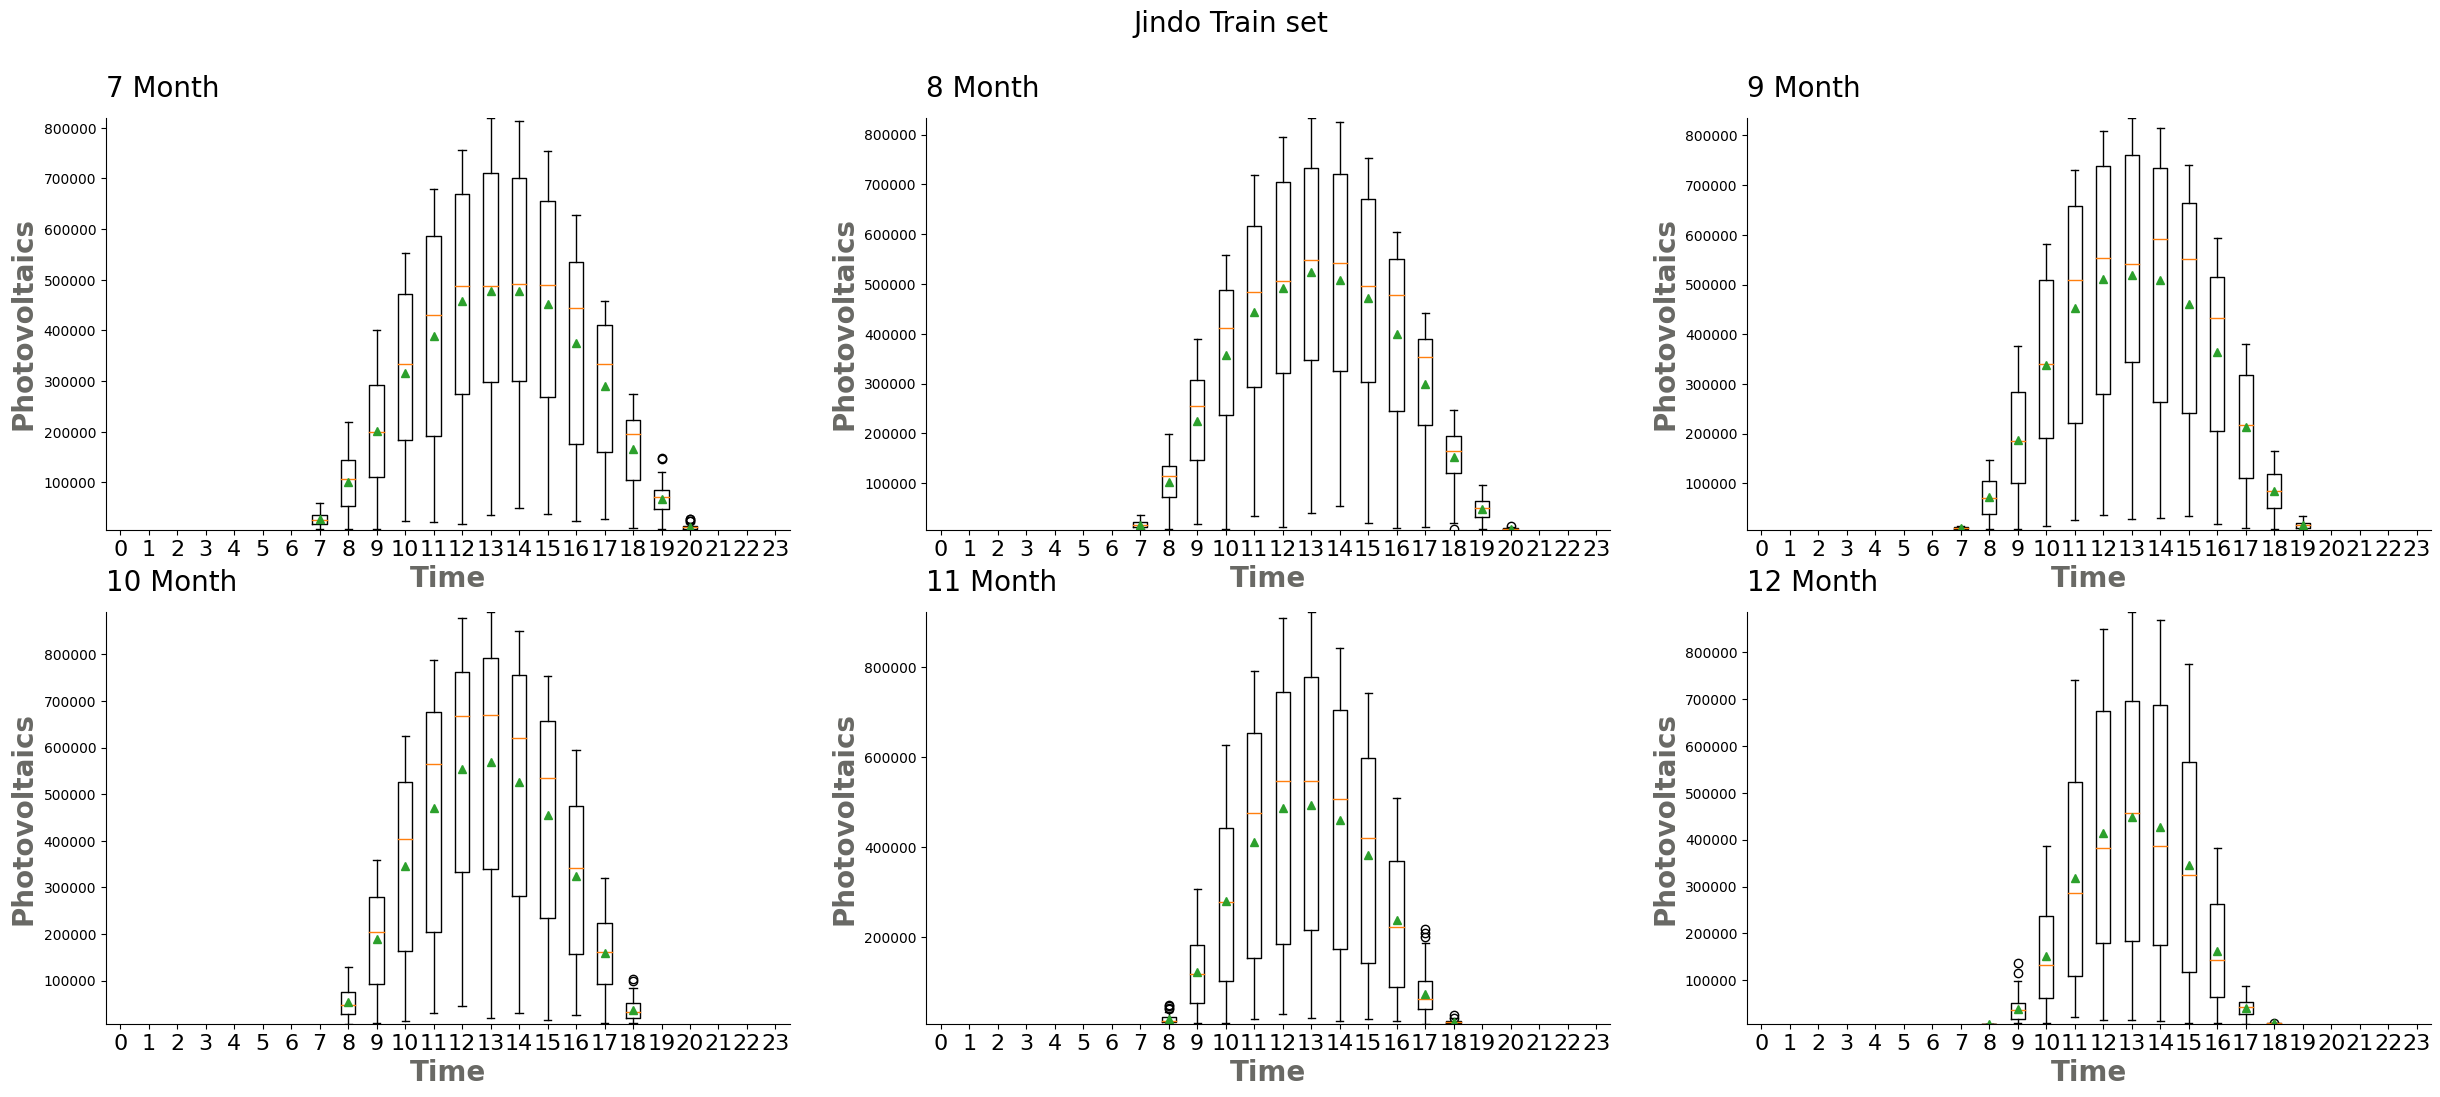

In [40]:
Months = range(7, 13)
Month_set(train_data, 'Jindo Train set', Months)

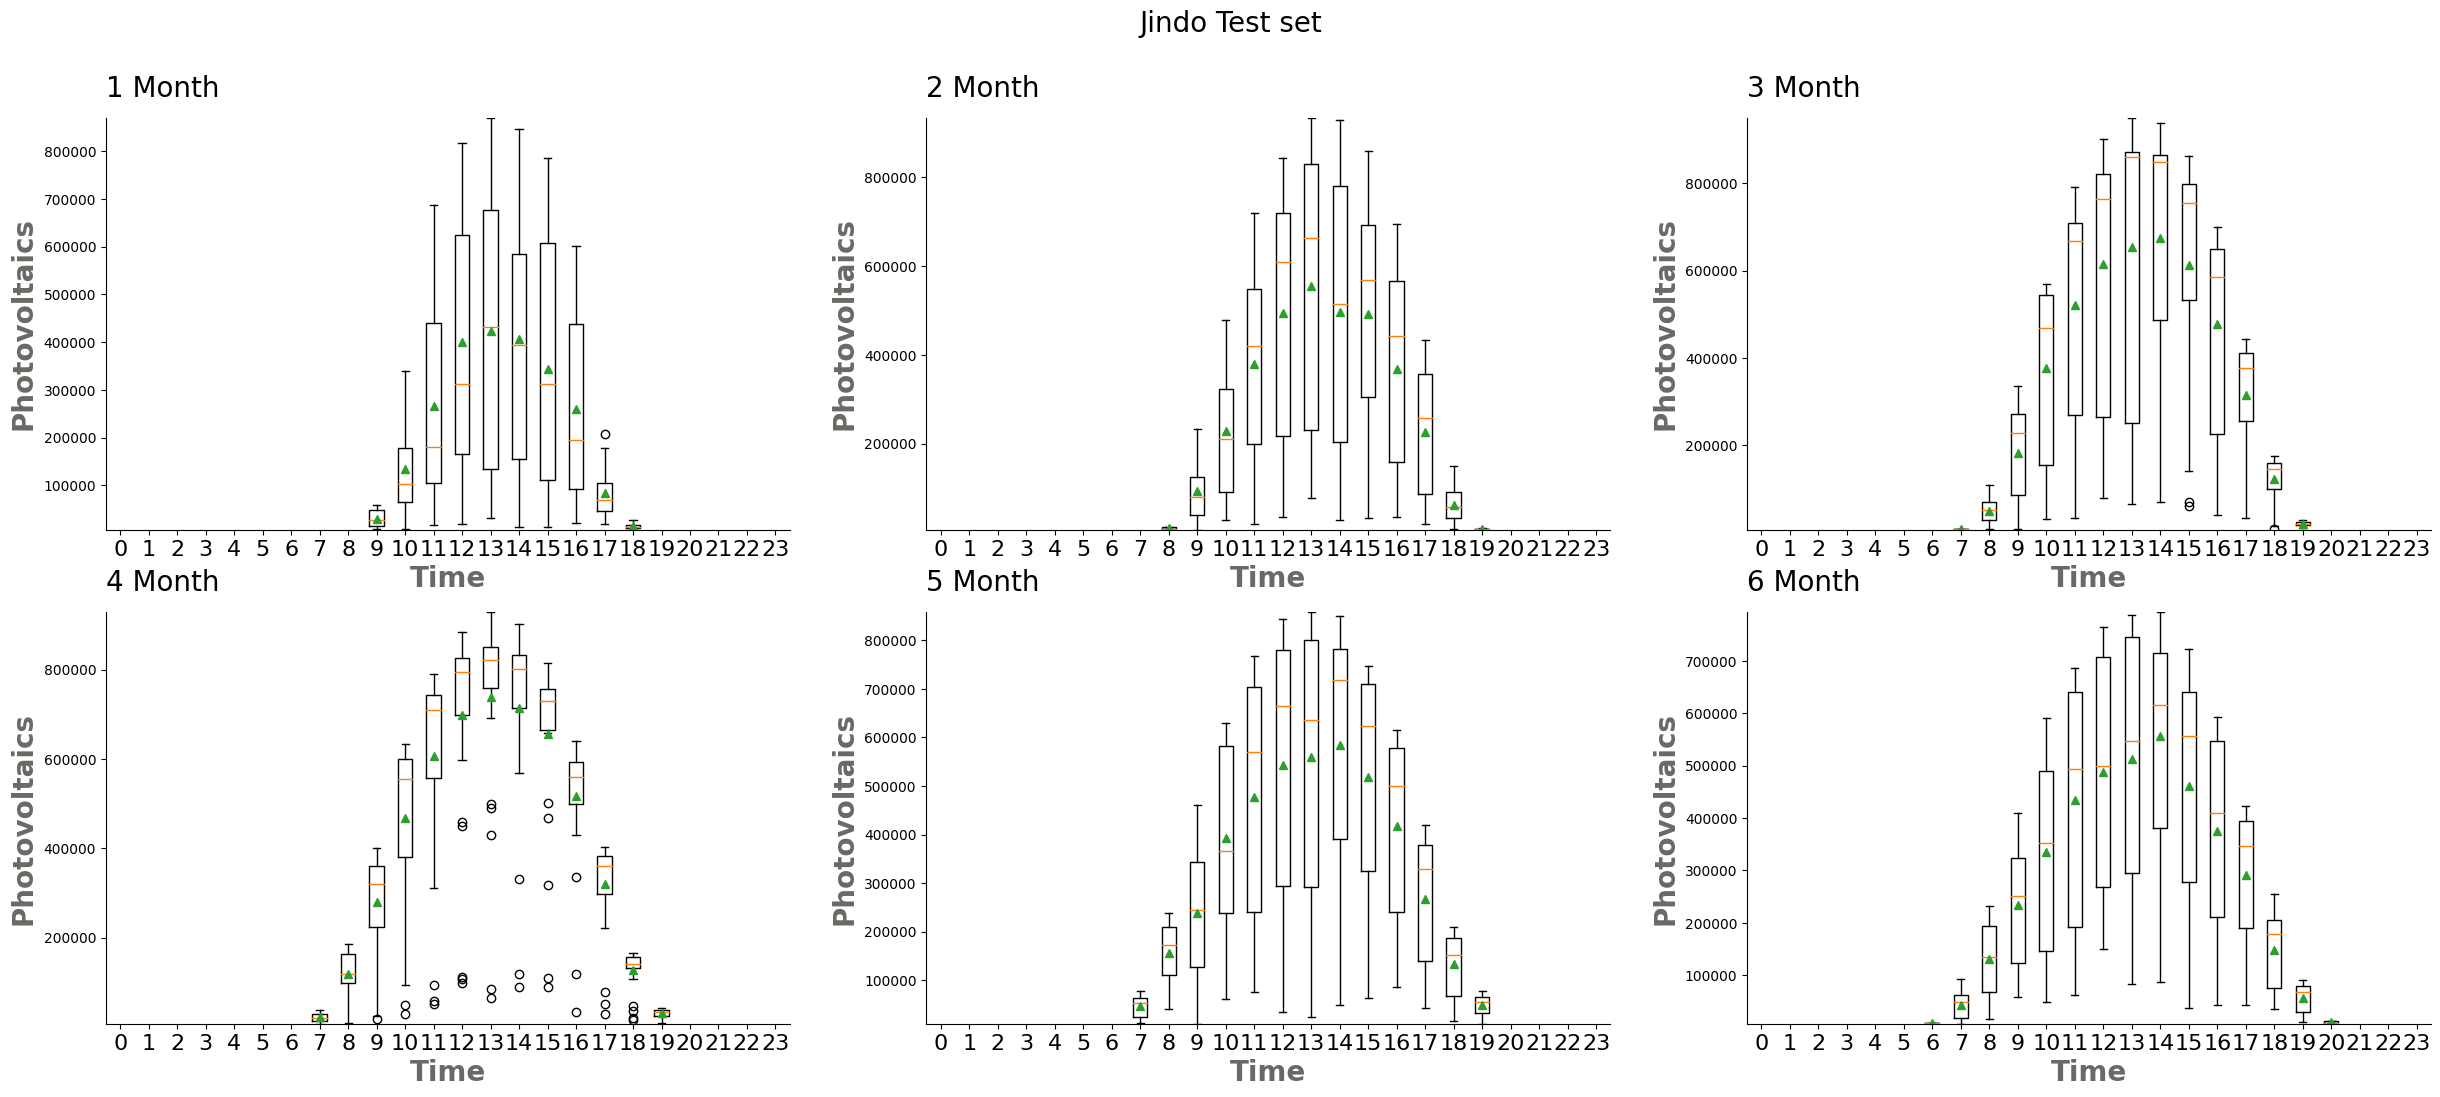

In [41]:
Months = range(1, 7)
Month_set(test_data, 'Jindo Test set', Months)

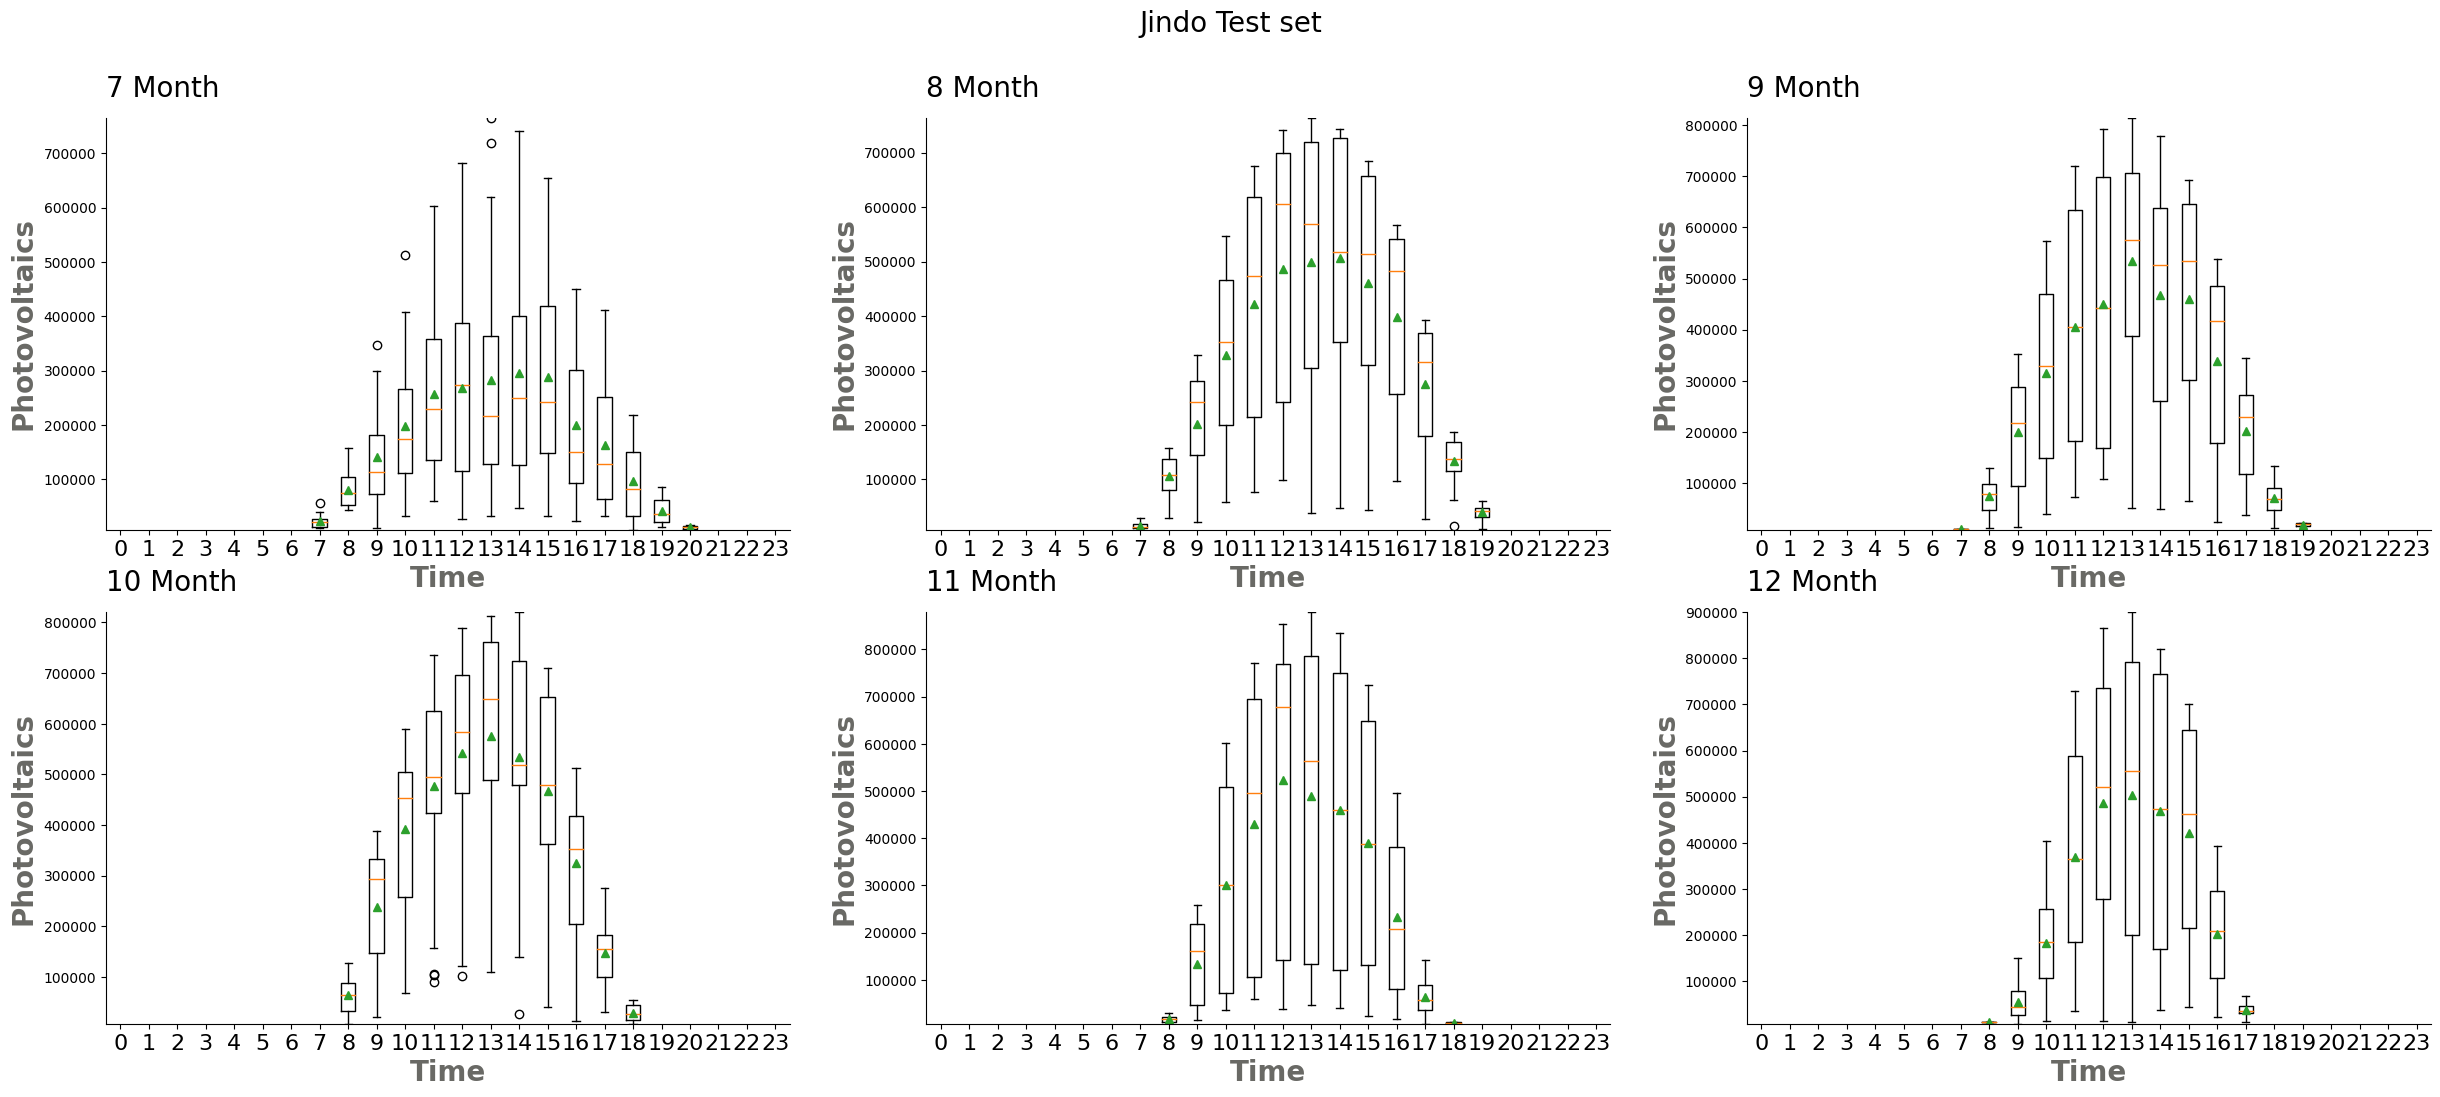

In [42]:
Months = range(7, 13)
Month_set(test_data, 'Jindo Test set', Months)

# Final Data
Remove missing values

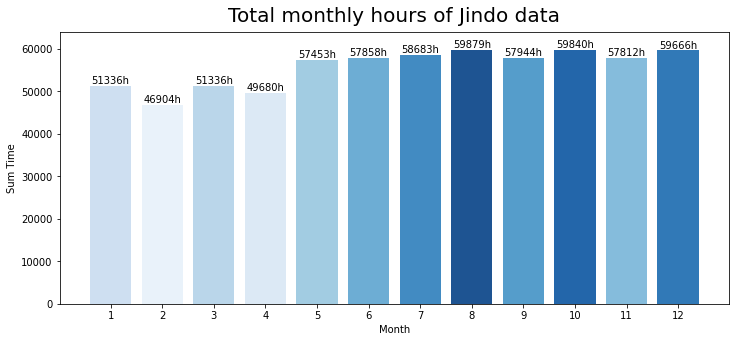

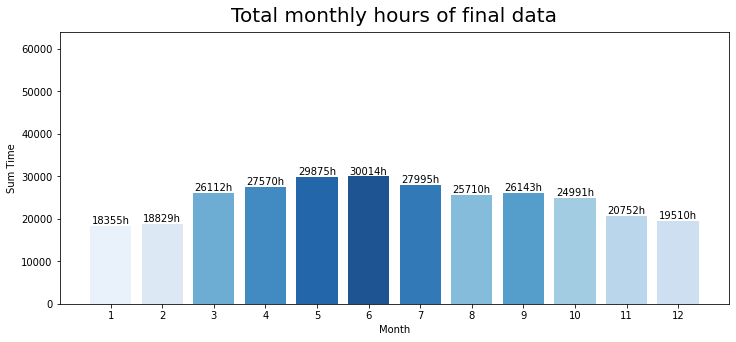

In [43]:
TimeBar(Jd_df, 'Jindo data', 64000)
TimeBar(result_Jd, 'final data', 64000)

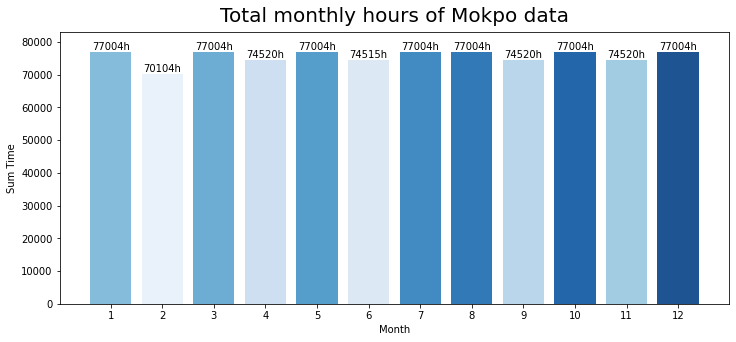

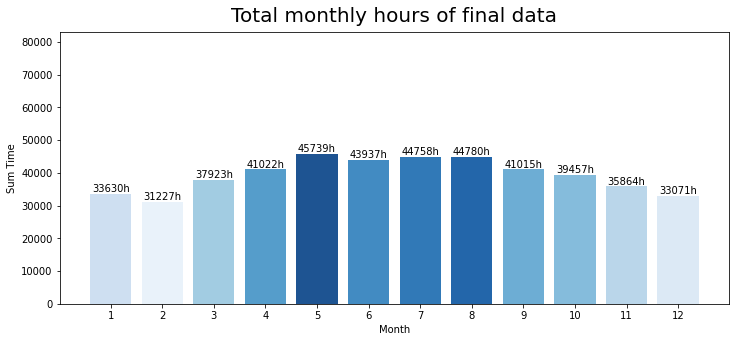

In [44]:
TimeBar(Mp_df, 'Mokpo data', 83000)
TimeBar(result_Mp, 'final data', 83000)

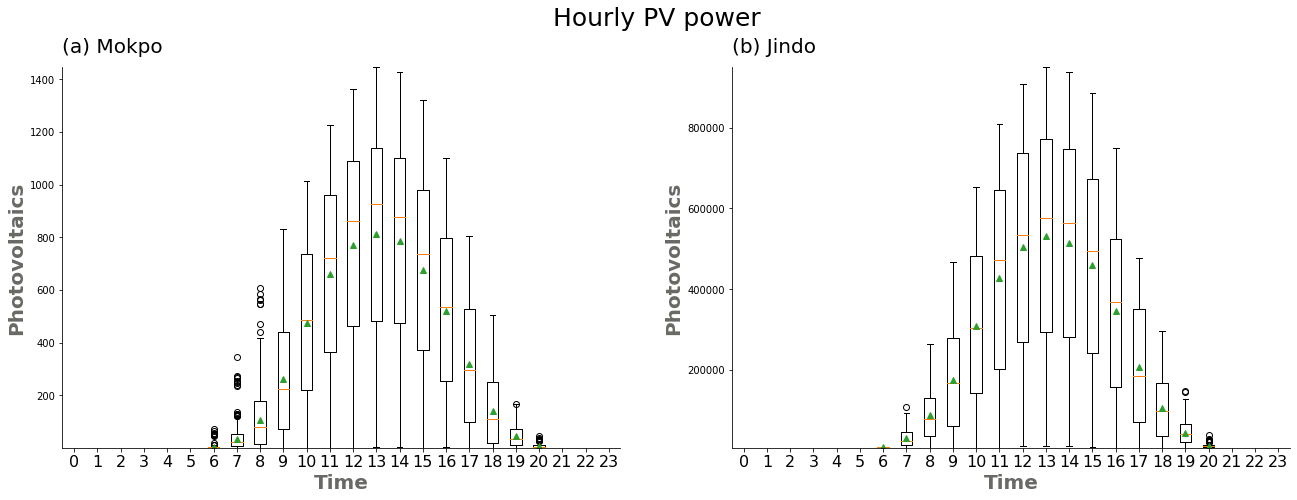

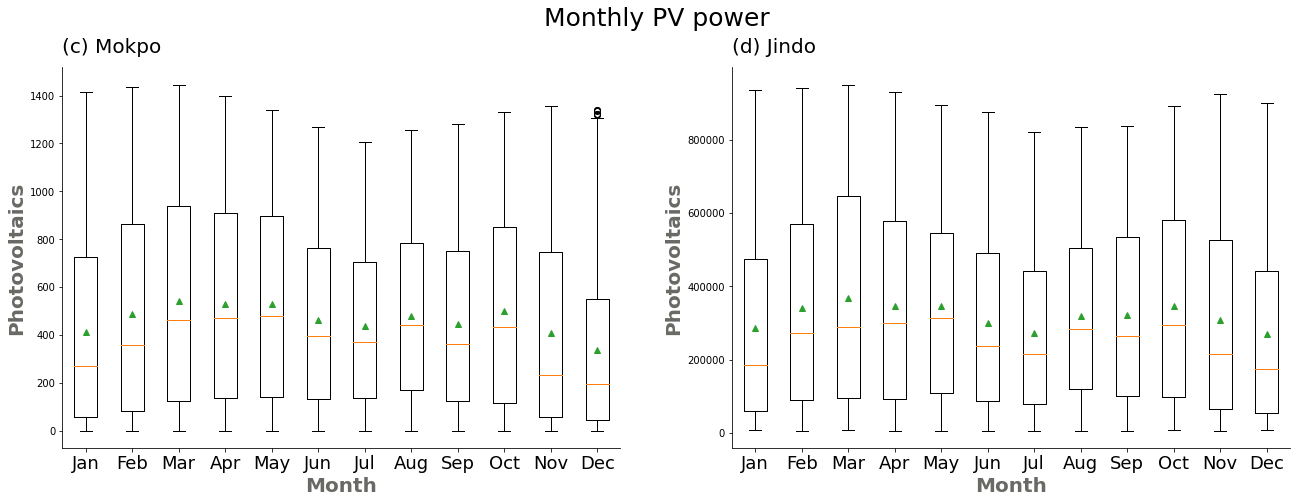

In [45]:
fig1, [ax1, ax2] = plt.subplots(figsize=(22, 7), nrows=1, ncols=2)
plt.suptitle('Hourly PV power', y= 1.0, fontsize=25)
Hourly_plot(result_Mp, 'Photovoltaics', ax1, '(a) Mokpo')
Hourly_plot(result_Jd, 'Photovoltaics', ax2, '(b) Jindo')

fig2, [ax3, ax4] = plt.subplots(figsize=(22, 7), nrows=1, ncols=2)
plt.suptitle('Monthly PV power', y= 1.0, fontsize=25)
Monthly_plot(result_Mp, 'Photovoltaics', ax3, '(c) Mokpo')
Monthly_plot(result_Jd, 'Photovoltaics', ax4, '(d) Jindo')

for i in [ax1, ax2, ax3, ax4]:
  ax = i
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

# Save data


In [46]:
result_Jd.to_csv('/content/gdrive/MyDrive/SolarPower/Train_Jd.csv', index=None) 
result_Mp.to_csv('/content/gdrive/MyDrive/SolarPower/Train_Mp.csv', index=None) 